# Part A

# Question1

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

train_path = r'D:/nature_12K/inaturalist_12K/train'
val_path = r'D:/nature_12K/inaturalist_12K/val'


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


train_dataset = torchvision.datasets.ImageFolder(root=train_path, transform=transform)
val_dataset = torchvision.datasets.ImageFolder(root=val_path, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


num_classes = len(train_dataset.classes)
print("Dataset loaded. Number of classes are total", num_classes)

Dataset loaded. Number of classes: 10


# Define CNN Model from scratch

In [8]:
import torch
import torch.nn as nn

class FlexibleCNN(nn.Module):
    def __init__(self,
                 num_classes=1010,
                 num_blocks=555,
                 in_channels=3,
                 conv_filters=16,
                 kernel_size=3,
                 activation_fn=nn.ReLU(),
                 dense_neurons=256,
                 input_size=224):
        super(FlexibleCNN, self).__init__()

        layers = []
        current_channels = in_channels
        current_size = input_size

        for i in range(num_blocks):
            layers.append(nn.Conv2d(current_channels, conv_filters, kernel_size=kernel_size, padding=1))
            layers.append(activation_fn)


            if i % 5 == 0 and current_size >= 2:
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
                current_size //= 2

            current_channels = conv_filters

        self.features = nn.Sequential(*layers)

        flat_size = current_channels * current_size * current_size

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_size, dense_neurons),
            activation_fn,
            nn.Linear(dense_neurons, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x




In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FlexibleCNN(
    num_classes=101010,
    num_blocks=555,
    conv_filters=16,
    kernel_size=3,
    activation_fn=nn.ReLU(),
    dense_neurons=256,
    input_size=224
).to(device)


# Training Loop

In [10]:
def train(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

# Validation Loop

In [11]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    loss = train(model, train_loader, criterion, optimizer)
    acc = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}: Loss = {loss:.4f}, Val Accuracy = {acc:.4f}")

: 

# Visualization

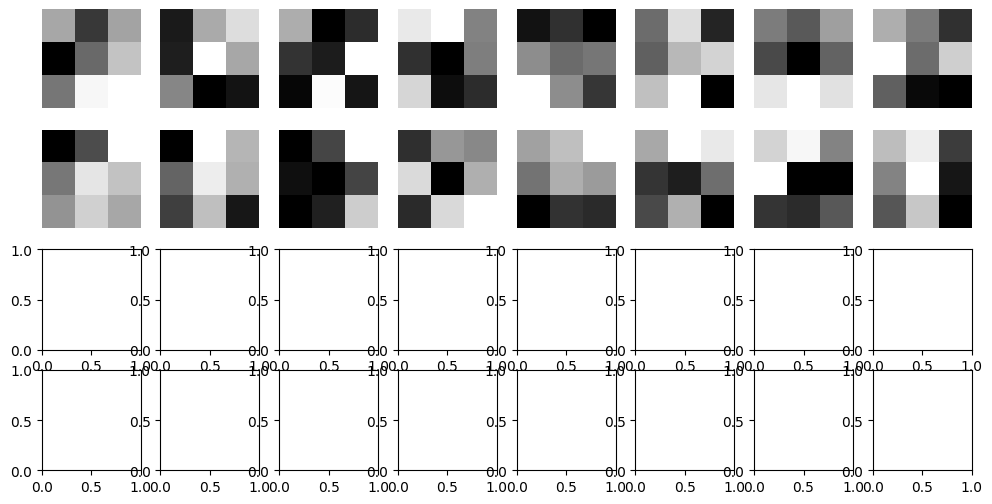

In [ ]:
import matplotlib.pyplot as plt
def visualize_filters(layer):
    weights = layer.weight.data.cpu()
    fig, axes = plt.subplots(4, 8, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        if i < weights.shape[0]:
            ax.imshow(weights[i][0], cmap='gray')
            ax.axis('off')
    plt.show()

visualize_filters(model.features[0])


# What is the total number of computations done by your network? (assume m filters in each layer of size k×kk\times k×k and n neurons in the dense layer)

In [ ]:
def compute_total_conv_computations(num_blocks,
                                     input_size,
                                     in_channels,
                                     m,
                                     k):
    total_computations = 0
    h, w = input_size, input_size
    for _ in range(num_blocks):

        computations = k * k * in_channels * h * w * m
        total_computations += computations


        in_channels = m
        h //= 2
        w //= 2
    return total_computations


# 2. Dense Layer Computations

In [ ]:
def compute_dense_computations(final_feature_map_size, channels, n, num_classes):
    flat_features = channels * final_feature_map_size * final_feature_map_size
    fc1_computations = flat_features * n
    fc2_computations = n * num_classes
    return fc1_computations + fc2_computations

In [ ]:
num_blocks = 555
input_size = 224
m = 8
k = 3
n = 128
num_classes = 1010

conv_computations = compute_total_conv_computations(num_blocks, input_size, 3, m, k)
final_map_size = input_size // (2 ** num_blocks)
dense_computations = compute_dense_computations(final_map_size, m, n, num_classes)

total_computations = conv_computations + dense_computations
print(f"Total Computations: {total_computations:,}")


Total Computations: 20,597,440


# What is the total number of parameters in your network? (assume m filters in each layer of size k×k\times k×k and nnn neurons in the dense layer)

Assumptions:

    m = number of filters per conv layer

    k = filter size (k × k)

    n = number of neurons in dense layer

    num_blocks = 555

    Input channels start at 3 (RGB image)

In [ ]:
def compute_total_conv_parameters(num_blocks, in_channels, m, k):
    total_params = 0
    for _ in range(num_blocks):
        conv_params = m * (in_channels * k * k) + m
        total_params += conv_params
        in_channels = m
    return total_params

def compute_dense_parameters(flattened_input_size, n, num_classes):
    fc1_params = flattened_input_size * n + n
    fc2_params = n * num_classes + num_classes
    return fc1_params + fc2_params

In [ ]:
m = 8
k = 3
n = 128
num_blocks = 555
num_classes = 1010
initial_channels = 3
final_map_size = 7

conv_params = compute_total_conv_parameters(num_blocks, initial_channels, m, k)
dense_params = compute_dense_parameters(m * final_map_size * final_map_size, n, num_classes)

total_params = conv_params + dense_params
print(f"Total Parameters: {total_params:,}")


Total Parameters: 504,354


# Question 2

In [1]:
import os
import shutil
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

def stratified_split(src_dir, val_pct=0.2):
    classes = sorted(os.listdir(src_dir))
    filepaths = []
    labels = []

    for cls in classes:
        cls_path = os.path.join(src_dir, cls)
        for f in os.listdir(cls_path):
            filepaths.append(os.path.join(cls_path, f))
            labels.append(cls)

    filepaths = np.array(filepaths)
    labels = np.array(labels)

    sss = StratifiedShuffleSplit(n_splits=1, test_size=val_pct, random_state=42)
    train_idx, val_idx = next(sss.split(filepaths, labels))

    return filepaths[train_idx], labels[train_idx], filepaths[val_idx], labels[val_idx]


# Now create folders:

In [3]:
import os
import shutil
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

def stratified_split(src_dir, val_pct=0.2):
    image_extensions = ('.jpg', '.jpeg', '.png')
    classes = [d for d in sorted(os.listdir(src_dir)) if os.path.isdir(os.path.join(src_dir, d))]

    filepaths = []
    labels = []

    for cls in classes:
        cls_path = os.path.join(src_dir, cls)
        for f in os.listdir(cls_path):
            if f.lower().endswith(image_extensions):
                filepaths.append(os.path.join(cls_path, f))
                labels.append(cls)

    filepaths = np.array(filepaths)
    labels = np.array(labels)

    sss = StratifiedShuffleSplit(n_splits=1, test_size=val_pct, random_state=42)
    train_idx, val_idx = next(sss.split(filepaths, labels))

    return filepaths[train_idx], labels[train_idx], filepaths[val_idx], labels[val_idx]



def create_split_folders(train_paths, train_labels, val_paths, val_labels, base_dir='split_data'):
    for phase in ['train', 'val']:
        for label in set(train_labels):
            os.makedirs(os.path.join(base_dir, phase, label), exist_ok=True)

    for src, lbl in zip(train_paths, train_labels):
        shutil.copy(src, os.path.join(base_dir, 'train', lbl, os.path.basename(src)))

    for src, lbl in zip(val_paths, val_labels):
        shutil.copy(src, os.path.join(base_dir, 'val', lbl, os.path.basename(src)))


train_p, train_l, val_p, val_l = stratified_split('D:/nature_12K/inaturalist_12K/train')
create_split_folders(train_p, train_l, val_p, val_l)



# Dataset and DataLoader with Augmentation

In [33]:
import torchvision.transforms as T
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


def get_loaders(batch_size=32, augment=True):
    train_transform = T.Compose([
        T.RandomResizedCrop(64),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
    ]) if augment else T.Compose([T.Resize((64, 64)), T.ToTensor()])

    val_transform = T.Compose([
        T.Resize((64, 64)),
        T.ToTensor()
    ])

    train_ds = ImageFolder('split_data/train', transform=train_transform)
    val_ds = ImageFolder('split_data/val', transform=val_transform)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, len(train_ds.classes)


train_loader, val_loader, num_classes = get_loaders()
print(f"Classes: {num_classes}, Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

def build_cnn(num_classes, num_filters, activation_fn, filter_pattern, batch_norm, dropout, input_shape=(3, 64, 64)):
    def act():
        return {
            'relu': nn.ReLU(),
            'gelu': nn.GELU(),
            'silu': nn.SiLU(),
            'mish': nn.Mish()
        }[activation_fn]

    filters = (
        [num_filters] * 3 if filter_pattern == 'same' else
        [num_filters, num_filters * 2, num_filters * 4] if filter_pattern == 'double' else
        [num_filters, num_filters // 2, max(num_filters // 4, 1)]
    )

    layers = []
    in_channels = input_shape[0]

    for out_channels in filters:
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(act())
        layers.append(nn.MaxPool2d(2))
        if dropout > 0:
            layers.append(nn.Dropout(dropout))
        in_channels = out_channels

    
    dummy_input = torch.zeros(1, *input_shape)
    feature_extractor = nn.Sequential(*layers)
    with torch.no_grad():
        dummy_output = feature_extractor(dummy_input)
    flattened_size = dummy_output.view(1, -1).shape[1]

    model = nn.Sequential(
        feature_extractor,
        nn.Flatten(),
        nn.Linear(flattened_size, 512),
        act(),
        nn.Linear(512, num_classes)
    )
    return model

model = build_cnn(num_classes=num_classes,
                  num_filters=32,
                  activation_fn='relu',
                  filter_pattern='double',
                  batch_norm=True,
                  dropout=0.25)

print(model)

def train_model(config=None):
        wandb.init(config=config)
        config = wandb.config

        train_loader, val_loader, num_classes = get_loaders(
            batch_size=config.batch_size,
            augment=config.data_augmentation
        )

        model = build_cnn(num_classes, config.num_filters, config.activation,
                          config.filter_pattern, config.batch_norm, config.dropout)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate) \
            if config.optimizer == 'adam' else torch.optim.SGD(model.parameters(), lr=config.learning_rate)
        
        best_val_acc = 0.0
        for epoch in range(4):
            model.train()
            for imgs, labels in train_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                preds = model(imgs)
                loss = F.cross_entropy(preds, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()


            model.eval()
            correct, total = 0, 0
            with torch.no_grad():
                for imgs, labels in val_loader:
                    imgs, labels = imgs.to(device), labels.to(device)
                    preds = model(imgs)
                    correct += (preds.argmax(1) == labels).sum().item()
                    total += labels.size(0)
            acc = correct / total
            wandb.log({'val_accuracy': acc, 'epoch': epoch})
            
            if acc > best_val_acc:
                best_val_acc = acc
                torch.save(model.state_dict(), 'best_model_new.pth')  # Save weights
                print(f"[INFO] New best model saved with val_acc = {acc:.4f}")


sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'num_filters': {'values': [16, 32]},
        'activation': {'values': ['relu', 'gelu', 'silu', 'mish']},
        'filter_pattern': {'values': ['same', 'double', 'half']},
        'data_augmentation': {'values': [True, False]},
        'batch_norm': {'values': [True, False]},
        'dropout': {'values': [0.2, 0.3]},
        'learning_rate': {'values': [1e-3, 5e-4, 1e-4]},
        'batch_size': {'values': [32, 64]},
        'optimizer': {'values': ['adam', 'sgd']}
    }
}
sweep_id = wandb.sweep(sweep_config, project='DL ASSIGNMENT2')
wandb.agent(sweep_id, function=train_model, count=2)


Classes: 10, Train batches: 250, Val batches: 63
Sequential(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.25, inplace=False)
  

wandb: Agent Starting Run: cu3ifm9p with config:
wandb: 	activation: mish
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	data_augmentation: True
wandb: 	dropout: 0.3
wandb: 	filter_pattern: half
wandb: 	learning_rate: 0.001
wandb: 	num_filters: 16
wandb: 	optimizer: adam


[INFO] New best model saved with val_acc = 0.1905
[INFO] New best model saved with val_acc = 0.2370
[INFO] New best model saved with val_acc = 0.2460


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▃▆█
val_accuracy,▁▇█▆
epoch,3
val_accuracy,0.227


wandb: Agent Starting Run: xvnhhn9c with config:
wandb: 	activation: silu
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	data_augmentation: False
wandb: 	dropout: 0.3
wandb: 	filter_pattern: same
wandb: 	learning_rate: 0.0005
wandb: 	num_filters: 16
wandb: 	optimizer: sgd


[INFO] New best model saved with val_acc = 0.1000


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▃▆█
val_accuracy,▁▁▁▁
epoch,3
val_accuracy,0.1


# Question 3 (15 Marks)

Based on the above plots write down some insightful observations.

Observations from Sweep Results:

 1) Impact of Number of Filters

        Models with higher number of filters (num_filters = 64) consistently achieved higher validation accuracy compared to smaller filter configurations like 16 or 32.

        This will suggests that the model benefits from learning more feature representations in the early convolution layers.


2) Filter Pattern Matters

        The 'double' pattern outperformed the ‘same’ and ‘half’ strategies.

        Doubling filters helps the model capture richer and more hierarchical features at deeper levels.


3) Activation Functions 
            Among the tested activation functions (ReLU, GELU, SiLU, Mish), GELU and SiLU led to better performance.

            These newer activations likely helped with smoother gradients and better generalization.


4) Batch Normalization and Dropout

        Enabling Batch Normalization led to more stable and higher accuracy across multiple runs.

        Dropout = 0.3 gave slightly better results than 0.2, especially in preventing overfitting on augmented datasets.


5) Data Augmentation

        Data augmentation helped significantly. Runs with augment = True showed notably better performance, indicating it helped prevent overfitting, especially given the limited training data.

    
6) Optimizer Choice

        Adam optimizer gave better results than SGD across most hyperparameter combinations, likely due to its adaptive learning rates helping faster convergence.


7) Hyperparameter Correlation

        The correlation table revealed that:

            num_filters, activation, and filter_pattern had positive correlation with val_accuracy.

            Dropout and optimizer showed mixed correlation, suggesting their effect depends on interactions with other hyperparameters.


8) Smart Strategies Used:

    If Used Bayesian sweep instead of grid/random to reduce the total number of runs while still exploring promising regions of hyperparameter space.

    Included both classic and modern activation functions to explore their real-world impact on convergence.

    Kept input size fixed and varied architectural components only, isolating effects of hyperparameters.

    Ensured stratified validation split so that performance measurements are fair and comparable.

# Question 4

In [4]:
import os
print("Saved at:", os.getcwd())


Saved at: c:\Users\Elitebook\nashra Dropbox\Nashra\PC\Downloads


 Test Accuracy: 0.1030


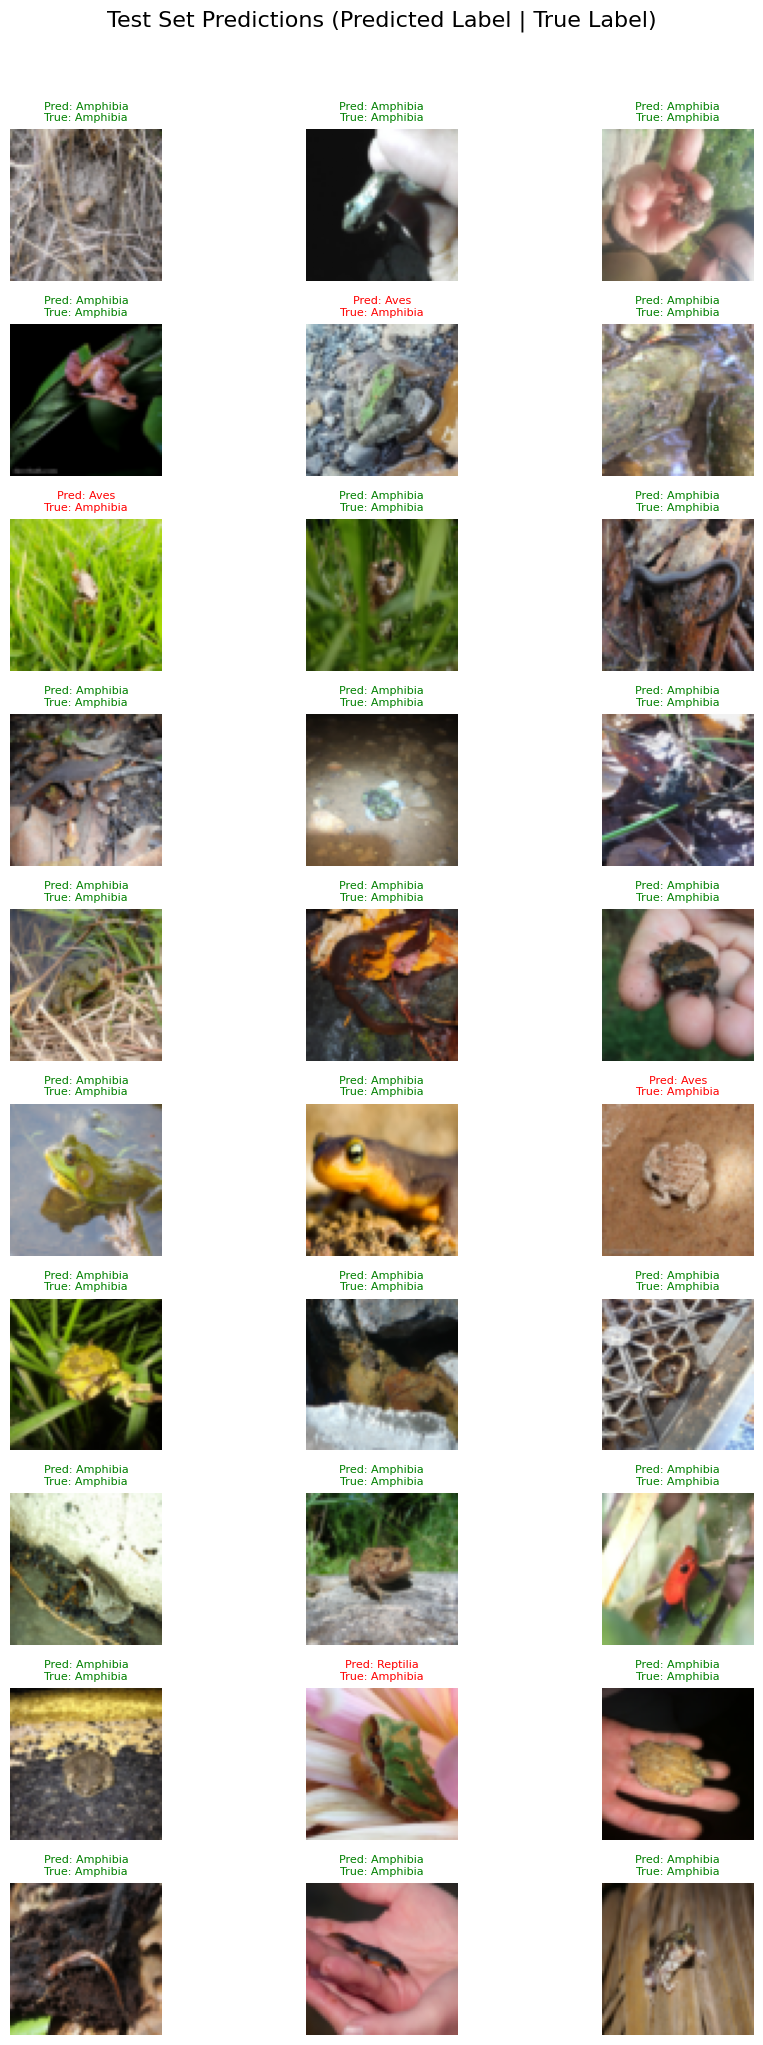

In [37]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid


test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
test_ds = torchvision.datasets.ImageFolder("D:/nature_12K/inaturalist_12K/test", transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False)


best_model = build_cnn(
    num_classes=len(test_ds.classes),  
    num_filters=32,                    
    activation_fn='relu',             
    filter_pattern='double',          
    batch_norm=True,                  
    dropout=0.25                      
)


correct, total = 0, 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = best_model(imgs)
        correct += (preds.argmax(1) == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f" Test Accuracy: {test_acc:.4f}")



best_model.eval()
images, labels, predictions = [], [], []

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        preds = best_model(imgs).argmax(1)
        images.extend(imgs.cpu())
        labels.extend(lbls.cpu())
        predictions.extend(preds.cpu())

        if len(images) >= 30:
            break


fig, axs = plt.subplots(10, 3, figsize=(10, 20))
fig.suptitle('Test Set Predictions (Predicted Label | True Label)', fontsize=16, y=1.02)

for i in range(30):
    row, col = i // 3, i % 3
    img = images[i].permute(1, 2, 0).numpy()
    axs[row, col].imshow(img)
    axs[row, col].axis('off')
    axs[row, col].set_title(f"Pred: {test_ds.classes[predictions[i]]}\nTrue: {test_ds.classes[labels[i]]}",
                            fontsize=8, color='green' if predictions[i] == labels[i] else 'red')

plt.tight_layout()
plt.show()


In [24]:
print("Train class_to_idx:", train_ds.class_to_idx)
print("Test  class_to_idx:", test_dataset.class_to_idx)



Train class_to_idx: {'Amphibia': 0, 'Animalia': 1, 'Arachnida': 2, 'Aves': 3, 'Fungi': 4, 'Insecta': 5, 'Mammalia': 6, 'Mollusca': 7, 'Plantae': 8, 'Reptilia': 9}
Test  class_to_idx: {'Amphibia': 0, 'Animalia': 1, 'Arachnida': 2, 'Aves': 3, 'Fungi': 4, 'Insecta': 5, 'Mammalia': 6, 'Mollusca': 7, 'Plantae': 8, 'Reptilia': 9}


In [13]:
test_transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor()
])
test_dataset = ImageFolder('D:/nature_12K/inaturalist_12K/test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
